In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from icedef import metocean, test_case
from icedef import statoil_arcticnet_data as sd

In [3]:
plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

In [79]:
beacon_id = '90679'  # good berg
#beacon_id = '50519'  # bad berg

df = sd.get_beacon_df(beacon_id=beacon_id)

    
if beacon_id == '90679':
    start_index = 816
elif beacon_id == '50519':
    start_index = 537

start_time = df.DataDate_UTC.values[start_index]
end_time = start_time + np.timedelta64(1, 'D')

tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

start_latitude = tc.start_latitude
start_longitude = tc.start_longitude

In [105]:
atm = metocean.Atmosphere((start_time, end_time))
ocean = metocean.Ocean((start_time, end_time))

In [81]:
m = Basemap(projection='stere', resolution='l', llcrnrlat=40, llcrnrlon=-60, urcrnrlat=60, urcrnrlon=-40, 
            lon_0=start_longitude, lat_0=start_latitude, lat_ts=start_latitude)

In [129]:
# field = atm.data
# velocity_field = atm.wind

# field_lons = field.longitude.values[:-1]
# field_lats = field.latitude.values
# field_times = field.time.values
# cbar_label = 'Wind speed (m/s)'
# cmap = 'plasma'
# vmin = 0
# vmax = 10
# arrow_scale = 0.8
# index_0 = 0
# index_12 = 3
# index_24 = -1
# num_grid_cells = 3

       
field = ocean.data
velocity_field = ocean.current

field_lons = field.longitude.values
field_lats = field.latitude.values
field_times = field.time.values
cbar_label = 'Current speed (m/s)'
cmap = 'viridis'
vmin = 0
vmax = 0.5
arrow_scale = 0.05
index_0 = 0
index_12 = 11
index_24 = 23

num_grid_cells = 20


def plot_metocean_field():
    
    start_x, start_y = m(start_longitude, start_latitude)

    field_xs, field_ys = m(field_lons, field_lats)
    berg_xs, berg_ys = m(tc.ref_lons.values, tc.ref_lats.values)

    field_xs -= start_x
    field_ys -= start_y
    field_xs /= 1000
    field_ys /= 1000

    berg_xs -= start_x
    berg_ys -= start_y
    berg_xs /= 1000
    berg_ys /= 1000

    x_index = np.argmin(abs(field_xs))
    x_index_0 = x_index - num_grid_cells // 2
    x_index_n = x_index + num_grid_cells // 2

    y_index = np.argmin(abs(field_ys))
    y_index_0 = y_index - num_grid_cells // 2
    y_index_n = y_index + num_grid_cells // 2

    velocities = velocity_field.eastward_velocities.values
    us_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    us_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    velocities = velocity_field.northward_velocities.values
    vs_0 = velocities[index_0, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_12 = velocities[index_12, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]
    vs_24 = velocities[index_24, y_index_0 : y_index_n + 1, x_index_0 : x_index_n + 1]

    xs = field_xs[x_index_0 : x_index_n + 1]
    ys = field_ys[y_index_0 : y_index_n + 1]

    xs_1 = np.append(xs, xs[-1] + np.mean(np.diff(xs))) - np.mean(np.diff(xs)) / 2
    ys_1 = np.append(ys, ys[-1] + np.mean(np.diff(ys))) - np.mean(np.diff(ys)) / 2
    xxs, yys = np.meshgrid(xs_1, ys_1)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharey=True, num='wind')
    u = us_0
    v = vs_0
    axs[0].set_xlabel('Position (km)')
    axs[0].set_ylabel('Position (km)')
    for ax, u, v in zip(axs, [us_0, us_12, us_24], [vs_0, vs_12, vs_24]):
        ax.set_aspect('equal')
        ax.pcolor(xxs, yys, np.sqrt(u**2 + v**2), cmap=cmap, vmin=vmin, vmax=vmax)
        ax.quiver(xs, ys, u, v, units='xy', angles='xy', color='white', scale=arrow_scale, zorder=1000)
        ax.scatter(berg_xs, berg_ys, marker='^', color='k')
        ax.set_ylim(-50, 50)
        ax.set_xlim(-50, 50)

    cm = ax.get_children()[0]
    cbar = fig.colorbar(cm)
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(f'{cbar_label}', rotation=90)

    fig.subplots_adjust(wspace=0, hspace=0)

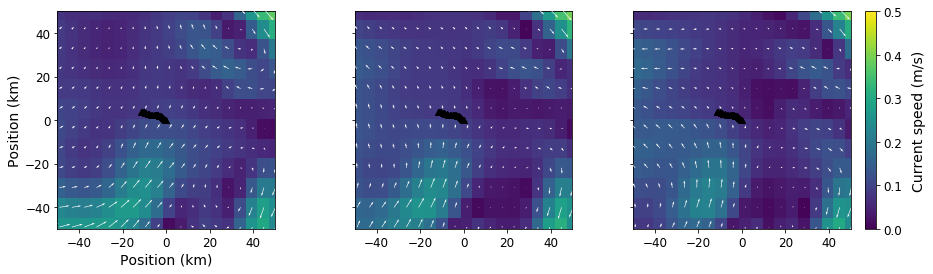

In [130]:
plot_metocean_field()